# Live cu-inj-live-impact 

In [1]:
# Setup directories, and convert dashboard notebook to a script for importing
#!./setup.bash

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from impact import evaluate_impact_with_distgen, run_impact_with_distgen
from impact.tools import isotime
from impact.evaluate import  default_impact_merit
from impact import Impact

from make_dashboard import make_dashboard
from get_vcc_image import get_live_distgen_xy_dist, VCC_DEVICE_PV

import matplotlib as mpl

from pmd_beamphysics.units import e_charge

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 5.01 µs


In [4]:
import pandas as pd
import numpy as np

import h5py
import json
import epics

import sys
import os
import toml
from time import sleep, time


import matplotlib.pyplot as plt

import matplotlib as mpl
#mpl.use('Agg')

# Nicer plotting
%config InlineBackend.figure_format = 'retina'

# Logging

In [5]:
#MODEL = 'f2e_inj'
#MODEL = 'cu_inj'
MODEL = 'sc_inj'

In [6]:
PREFIX = f'lume-impact-live-demo-{MODEL}'

In [7]:
import logging

# Gets or creates a logger
logger = logging.getLogger(PREFIX)  

# set log level
logger.setLevel(logging.INFO)

# define file handler and set formatter
file_handler = logging.FileHandler(f'{PREFIX}.log')
#formatter    = logging.Formatter('%(asctime)s : %(levelname)s : %(name)s : %(message)s')
formatter    = logging.Formatter(fmt="%(asctime)s :  %(name)s : %(message)s ", datefmt="%Y-%m-%dT%H:%M:%S%z")

# Add print to stdout
logger.addHandler(logging.StreamHandler(sys.stdout))

file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

# Configuration

Set up basic input sources and output path, loaded from toml environment file.

See README for required toml definition.

In [8]:
DEBUG=False
USE_VCC = False


config = toml.load("local_sc_inj.toml")

WORKDIR=config.get('workdir')
if not WORKDIR:
    raise ValueError("workdir not defined in toml.")


HOST = config.get('host') # mcc-simul or 'sdf'
if not HOST:
    raise ValueError("host not defined in toml.")

    
def get_path(key):
    val = config.get(key)
    if not val:
        raise ValueError(f"{key} not defined in toml.")
    val=os.path.expandvars(val)
    if not os.path.exists(val):
        raise ValueError(f"{val} does not exist")
    return os.path.abspath(val)
    
IMPACT_CONFIG_FILE = get_path('config_file')

DISTGEN_INPUT_FILE = get_path('distgen_input_file')
    
SUMMARY_OUTPUT_DIR = get_path('summary_output_dir')

PLOT_OUTPUT_DIR = get_path('plot_output_dir')

ARCHIVE_DIR = get_path('archive_dir')

SNAPSHOT_DIR = get_path('snapshot_dir')


# Dummy file for distgen
DISTGEN_LASER_FILE = config.get('distgen_laser_file')
if not DISTGEN_LASER_FILE:
    raise ValueError("distgen_laser_file not defined in toml.")

# Number of processors
NUM_PROCS = config.get('num_procs')
if not NUM_PROCS:
    raise ValueError("num_procs not defined in toml.")
else:
    NUM_PROCS = int(NUM_PROCS)


# if using sdf:
if HOST == 'sdf':    
    # check that environment variables are configured for execution
    IMPACT_COMMAND = config.get("impact_command")
    if not IMPACT_COMMAND:
        raise ValueError("impact_command not defined in toml.")


    IMPACT_COMMAND_MPI = config.get("impact_command_mpi")
    if not IMPACT_COMMAND_MPI:
        raise ValueError("impact_command_mpi not defined in toml.")


# MPI_RUN_CMD = config.get("mpi_run_cmd")
# if not MPI_RUN_CMD:
#     raise ValueError("mpi_run_cmd not defined in toml.")

In [9]:
CONFIG0 = {}

# Base settings
SETTINGS0 = {
 'distgen:n_particle': 10_000,   
 'timeout': 10000,
 'header:Nx': 32,
 'header:Ny': 32,
 'header:Nz': 32,
 'numprocs': NUM_PROCS,
# 'mpi_run': MPI_RUN_CMD
   }

SETTINGS0['numprocs'] = NUM_PROCS
CONFIG0["workdir"] = WORKDIR

if DEBUG:
    logger.info('DEBUG MODE: Running without space charge for speed. ')
    SETTINGS0['distgen:n_particle'] = 1000
    SETTINGS0['total_charge'] = 0
    
    
elif HOST in ('sdf', ):
    
     # SDF setup 
    SETTINGS0['command'] =  IMPACT_COMMAND
    SETTINGS0['command_mpi'] =  IMPACT_COMMAND_MPI
    
elif HOST == 'local':
    logger.info('Running locally')
    
else:
    raise ValueError(f'Unknown host: {HOST}')
    

Running locally


# Select: LCLS or FACET

In [10]:
# PV -> Sim conversion table
CSV =  f'pv_mapping/{MODEL}_impact.csv'  


CONFIG0['impact_config']      =  IMPACT_CONFIG_FILE
CONFIG0['distgen_input_file'] =  DISTGEN_INPUT_FILE


if MODEL == 'cu_inj':
    VCC_DEVICE = 'CAMR:IN20:186' # LCLS   
    
    DASHBOARD_KWARGS = {'outpath':PLOT_OUTPUT_DIR,
                    'screen1': 'YAG02',
                    'screen2': 'YAG03',
                    'screen3': 'OTR2',
                    'ylim' : (0, None), # Emittance scale   
                    'ylim2': (0, None), # sigma_x scale
                    'name' : PREFIX
                   }    
    
    SETTINGS0['stop'] = 16.5
    SETTINGS0['distgen:t_dist:length:value'] =  4 * 1.65   #  Inferred pulse stacker FWHM: 4 ps, converted to tukey length
    
if MODEL == 'sc_inj':
    VCC_DEVICE = 'CAMR:LGUN:950' # LCLS-II 
    
    DASHBOARD_KWARGS = {'outpath':PLOT_OUTPUT_DIR,
                    'screen1': 'YAG01B',
                    'screen2': 'BEAM0',
                    'screen3': 'OTR0H04',
                    'ylim' : (0, 3e-6), # Emittance scale   
                    'ylim2': (0, None), # sigma_x scale                    
                    'name' : PREFIX
                   }    
    
    SETTINGS0['stop'] = 28
    SETTINGS0['distgen:t_dist:sigma_t:value'] =  16 / 2.355   # ps, Inferred pulse stacker FWHM: 18 ps FWHM
    
elif MODEL == 'f2e_inj':
    VCC_DEVICE = 'CAMR:LT10:900' # FACET-II
    
    DASHBOARD_KWARGS = {'outpath':PLOT_OUTPUT_DIR,
                    'screen1': 'PR10241',
                    'screen2': 'PR10465',
                    'screen3': 'PR10571',
                    'ylim' : (0, 20e-6), # Emittance scale
                    'name' : PREFIX
                   }        
    
    SETTINGS0['distgen:t_dist:length:value'] =  3.65 * 1.65   #  Measured FWHM: 3.65 ps, converted to tukey length
     
else:
    raise

# Set up monitors

In [11]:
# Gun: 700 kV
# Buncher: 200 keV energy gain
# Buncher: +60 deg relative to on-crest

In [12]:
DF = pd.read_csv(CSV)#.dropna()

PVLIST = list(DF['device_pv_name'].dropna()) 
if USE_VCC:
    PVLIST = PVLIST + list(VCC_DEVICE_PV[VCC_DEVICE].values())

#DF.set_index('device_pv_name', inplace=True)
DF

,Variable,bmad_name,device_pv_name,pv_unit,impact_name,impact_factor,impact_offset,impact_description,impact_unit
0,Gun Voltage,RFGUNB,SOLN:GUNB:212:BACT,xxx,RFGUNB:rf_field_scale,0.000000e+00,18200000.00,NaN,NaN
1,Solenoid 1,SOL1B,SOLN:GUNB:212:BACT,kG*m,SOL1B:solenoid_field_scale,1.159555e+00,0.00,peak field,T
2,Solenoid 2,SOL2B,SOLN:GUNB:823:BACT,kG*m,SOL2B:solenoid_field_scale,1.159555e+00,0.00,peak field,T
3,charge,CATHODE,BPMS:GUNB:314:TMIT,n_electrons,distgen:total_charge:value,1.600000e-07,0.00,total charge on cathode,pC
4,Buncher Voltage,BUN1B,ACCL:GUNB:455:AACT_AVG,MV,BUN1B:rf_field_scale,0.000000e+00,1707653.93,peak on-axis electric field,V/m
5,Buncher Phase,BUN1B,ACCL:GUNB:455:PACT_AVG,deg,BUN1B:autophase_deg,0.000000e+00,-60.00,phase relative to on-crest,deg
6,Cavity 1 voltage,CAVL011,ACCL:L0B:0110:AACTMEAN,MV,CAVL011:rf_field_scale,1.861947e+06,0.00,peak on-axis electric field,V/m
7,Cavity 2 voltage,CAVL012,ACCL:L0B:0120:AACTMEAN,MV,CAVL012:rf_field_scale,1.861947e+06,0.00,peak on-axis electric field,V/m
8,Cavity 3 voltage,CAVL013,ACCL:L0B:0130:AACTMEAN,MV,CAVL013:rf_field_scale,1.861947e+06,0.00,peak on-axis electric field,V/m
9,Cavity 4 voltage,CAVL014,ACCL:L0B:0140:AACTMEAN,MV,CAVL014:rf_field_scale,1.861947e+06,0.00,peak on-axis electric field,V/m


In [13]:
MONITOR = {pvname:epics.PV(pvname) for pvname in PVLIST}
sleep(5)

In [14]:
def get_pvdata():
        
    itime = isotime()
    pvdata =  {k:MONITOR[k].get() for k in MONITOR}
    
    logger.info(f'Acquired settings from EPICS at: {itime}')
    
    for k, v in pvdata.items():
        
        if v is None:
            raise ValueError(f'EPICS get for {k} returned None')
        
        if ':IMAGE:ARRAYDATA' in k.upper():
            found = False
            while not found:
                if v is None:
                    continue
                if v.std() > 10:
                    found = True
                else:
                    v = MONITOR[k].get()
            if v.ptp() < 128:
                v = v.astype(np.int8) # Downcast preeptively 
                                
            pvdata[k] = v
    return pvdata, itime
# PVDATA, ITIME = get_pvdata()
# PVDATA, ITIME

In [15]:
# Saving and loading
def save_pvdata(filename, pvdata, isotime):
    with h5py.File(filename, 'w') as h5:
        h5.attrs['isotime'] = np.string_(isotime)
        for k, v in pvdata.items():
            if isinstance(v, str):
                v =  np.string_(v)
            h5[k] = v 
def load_pvdata(filename):
    pvdata = {}
    with h5py.File(filename, 'r') as h5:
        isotime = h5.attrs['isotime']
        for k in h5:
            v = np.array(h5[k])        
            if v.dtype.char == 'S':
                v = str(v.astype(str))
            pvdata[k] = v
            
    return pvdata, isotime
# save_pvdata('test.h5', PVDATA, isotime()) 
# load_pvdata('test.h5')

In [16]:
#while True:
#    get_pvdata()

# EPICS -> Simulation settings

In [17]:
def get_live_settings(csv, base_settings={}, snapshot_dir=None):
    """
    Fetches live settings for all devices in the CSV table, and translates them to simulation inputs
     
    """
    df = DF[DF['device_pv_name'].notna()]
    assert len(df) > 0, 'Empty dataframe!'
    
    pv_names = list(df['device_pv_name'])

    pvdata, itime = get_pvdata()
    
    if snapshot_dir:
        filename = os.path.abspath(os.path.join(snapshot_dir, f'{MODEL}-snapshot-{itime}.h5'))
        logger.info(f'EPICS shapshot written: {filename}')
        save_pvdata(filename, pvdata, itime)
        # DEBUG: check readback
        #pvdata, itime = load_pvdata(filename)
        
    #df['pv_value'] = epics.caget_many(pv_names)
    df['pv_value'] = [pvdata[k] for k in pv_names]
    
    # Assign impact
    df['impact_value'] = df['impact_factor']*df['pv_value'] 
    if 'impact_offset' in df:
        df['impact_value'] = df['impact_value']  + df['impact_offset']

    # Collect settings
    settings = base_settings.copy()
    settings.update(dict(zip(df['impact_name'], df['impact_value'])))
    
    if DEBUG:
        settings['total_charge'] = 0
    else:
        settings['total_charge'] = 1 # Will be updated with particles

    # VCC image
    if USE_VCC:
        dfile, img, cutimg = get_live_distgen_xy_dist(filename=DISTGEN_LASER_FILE, vcc_device=VCC_DEVICE, pvdata=pvdata)        
    else:
        img, cutimg = None, None
        #settings['distgen:r_dist:max_r:value'] = 0.35 # TEMP        
    
    return settings, df, img, cutimg, itime

#res = get_live_settings(CSV, SETTINGS0, snapshot_dir='.')
#DF[['Variable', 'bmad_name', 'pv_value','pv_unit',  'device_min', 'device_max',  'impact_name', 'impact_factor', 'impact_unit',
#        'impact_description',  'impact_value']]
#res[1]

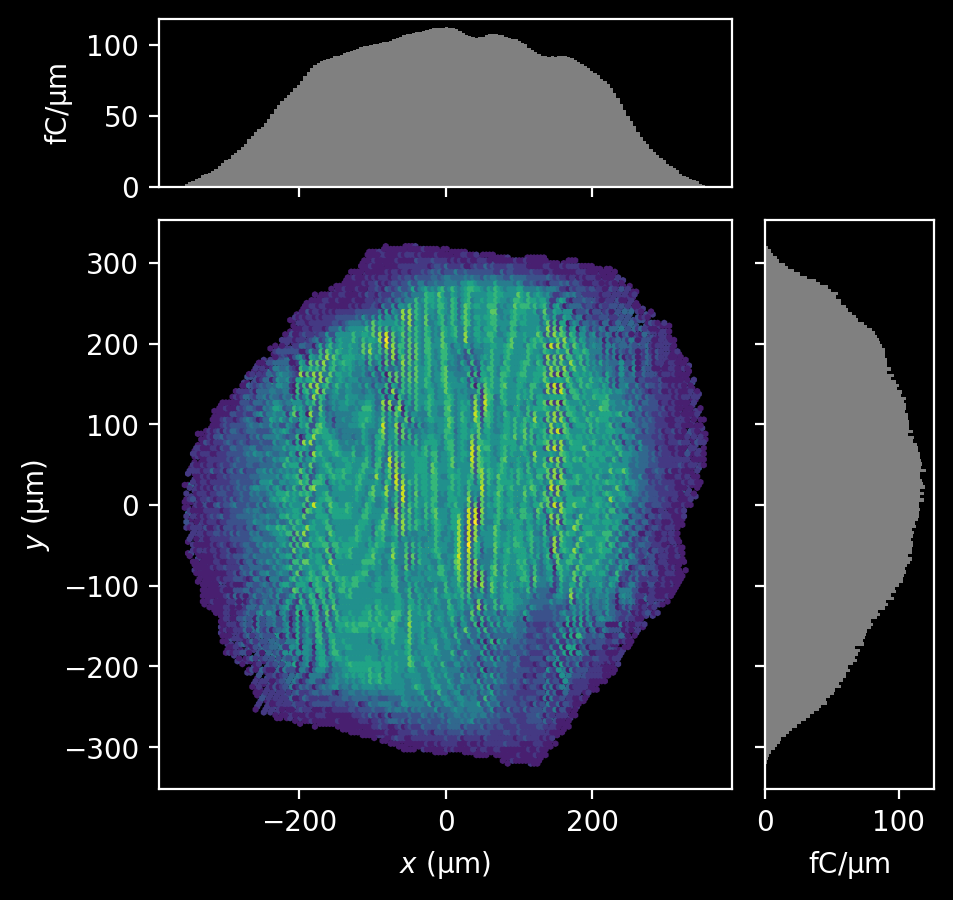

In [18]:
# gfile = CONFIG0['distgen_input_file']
# from distgen import Generator
# #fout = res[0]
# G = Generator(gfile)
# #G['xy_dist:file'] =  DISTGEN_LASER_FILE #'distgen_laser.txt'
# if USE_VCC:
#     G['xy_dist:file'] = res[0]['distgen:xy_dist:file'] 
# G['n_particle'] = 100000
# G.run()
# G.particles.plot('x', 'y', figsize=(5,5))

In [22]:
DO_TIMING = False

if DO_TIMING:
    import numpy as np
    import time
    results = []
    tlist = []
    nlist = 2**np.arange(1,8, 1)[::-1]
    for n in nlist:
        t1 = time.time()
        LIVE_SETTINGS['numprocs'] = n
        print(f'running wit {n}')
        result = run_impact_with_distgen(LIVE_SETTINGS, **CONFIG0, verbose=False )
        results.append(result)
        dt = time.time() - t1
        tlist.append(dt)
        print(n, dt)     
        
    tlist, nlist        

# Get live values, run Impact-T, make dashboard

In [23]:
# Patch this into the function below for the dashboard creation
def my_merit(impact_object, itime):
    # Collect standard output statistics
    merit0 = default_impact_merit(impact_object)
    # Make the dashboard from the evaluated object
    plot_file = make_dashboard(impact_object, itime=itime, **DASHBOARD_KWARGS)
    #print('Dashboard written:', plot_file)
    logger.info(f'Dashboard written: {plot_file}')
    
    # Assign extra info
    merit0['plot_file'] = plot_file    
    merit0['isotime'] = itime
    
    # Clear any buffers
    plt.close('all')

    return merit0

In [24]:
def run1():
    dat = {}
    
    # Acquire settings
    mysettings, df, img, cutimg, itime = get_live_settings(CSV, SETTINGS0, snapshot_dir=SNAPSHOT_DIR)
        
    dat['isotime'] = itime
    
    # Record inputs
    dat['inputs'] = mysettings
    dat['config'] = CONFIG0
    dat['pv_mapping_dataframe'] = df.to_dict()
    
    logger.info(f'Running evaluate_impact_with_distgen...')

    t0 = time()
    outputs = evaluate_impact_with_distgen(mysettings,
                                       merit_f=lambda x: my_merit(x, itime),
                                       archive_path=ARCHIVE_DIR,
                                       **CONFIG0, verbose=True )
    
    dat['outputs'] =  outputs   
    logger.info(f'...finished in {(time()-t0)/60:.1f} min')
    fname = fname=f'{SUMMARY_OUTPUT_DIR}/{PREFIX}-{itime}.json'
    json.dump(dat, open(fname, 'w'))
    #print('Written:', fname)
    logger.info(f'Output written: {fname}')
    return dat
    

In [25]:
#%%time
#result = run1()

In [26]:
# result.keys()

NameError: name 'result' is not defined

In [ ]:
# Basic config
#result['config']

In [ ]:
# Simulation inputs
#result['inputs']

In [ ]:
# Simulation outputs
# result['outputs']

# Show the plot 

In [ ]:
#from IPython.display import Image
#Image(filename=result['outputs']['plot_file'])

# loop it


In [ ]:
if __name__ == '__main__':
    while True:
        try:
            run1()
        except:
            sleep(10)
            logger.info('Something BAD happened. Sleeping for 10 s ...')